In [1]:
#!pip install torchinfo

In [2]:
import torch
print("PyTorch versio:", torch.__version__)
print("CUDA GPU saatavilla:", torch.cuda.is_available())
print("Käytössä oleva GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Ei GPU:ta")

#tf_df = pd.read_csv(r"D:\\Koulu\\AIDA_S24\\AIDA_project\\aida-projekti-local\\archive\\final_df.csv")

PyTorch versio: 2.5.1
CUDA GPU saatavilla: True
Käytössä oleva GPU: NVIDIA GeForce RTX 4080 SUPER


In [3]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Lataa data
tf_df = pd.read_csv(r"D:\\Koulu\\AIDA_S24\\AIDA_project\\aida-projekti-local\\archive\\final_df.csv")
tf_df = tf_df.drop(columns=['daysonmarket'])

# Varmista, että listed_date on datetime-muotoa
tf_df['listed_date'] = pd.to_datetime(tf_df['listed_date'], errors='coerce')

# Tarkista mahdolliset virheet konversiossa
if tf_df['listed_date'].isnull().sum() > 0:
    print("Huomio: listed_date-sarakkeessa on epäkelpoja arvoja, jotka muutetaan NaT-arvoiksi.")
    print(tf_df['listed_date'].isnull().sum(), "epäkelpoa riviä.")

# Lisää kuukauden ja viikonpäivän sarakkeet, jos listed_date on oikein konvertoitu
if not tf_df['listed_date'].isnull().all():
    tf_df['listed_month'] = tf_df['listed_date'].dt.month
    tf_df['listed_dayofweek'] = tf_df['listed_date'].dt.dayofweek
else:
    print("Ei kelvollisia päivämääriä listed_date-sarakkeessa.")

# Extract components from the listed_date column
tf_df['listed_month'] = tf_df['listed_date'].dt.month
tf_df['listed_dayofweek'] = tf_df['listed_date'].dt.dayofweek

# Apply cyclical encoding
tf_df['month_sin'] = np.sin(2 * np.pi * tf_df['listed_month'] / 12)
tf_df['month_cos'] = np.cos(2 * np.pi * tf_df['listed_month'] / 12)

tf_df['day_sin'] = np.sin(2 * np.pi * tf_df['listed_dayofweek'] / 7)
tf_df['day_cos'] = np.cos(2 * np.pi * tf_df['listed_dayofweek'] / 7)

# Drop the original and intermediate columns
tf_df.drop(columns=['listed_date', 'listed_month', 'listed_dayofweek'], inplace=True)

tf_df.describe()

,back_legroom,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,front_legroom,fuel_tank_volume,has_accidents,height,...,major_options_Blind Spot Monitoring,major_options_Android Auto,major_options_Parking Sensors,major_options_Adaptive Cruise Control,major_options_Other Option,make_encoded,month_sin,month_cos,day_sin,day_cos
count,1.830480e+06,1.830480e+06,1.830480e+06,1.830480e+06,1.830480e+06,1.830480e+06,1.830480e+06,1.830480e+06,1.830480e+06,1.830480e+06,...,1.830480e+06,1.830480e+06,1.830480e+06,1.830480e+06,1.830480e+06,1.830480e+06,1.830480e+06,1.830480e+06,1.830480e+06,1.830480e+06
mean,3.790363e+01,5.051453e+04,2.776551e+03,5.739085e-01,4.550856e-01,8.399578e-01,4.220093e+01,1.783218e+01,5.231071e-01,6.511829e+01,...,2.880736e-01,2.997940e-01,1.902905e-01,1.768378e-01,5.414705e-01,2.358017e+01,-5.017648e-01,-3.886692e-01,-2.035852e-02,-2.437086e-01
std,2.973164e+00,2.727736e+04,1.212500e+03,4.945075e-01,4.979787e-01,3.666453e-01,1.407061e+00,4.739855e+00,4.994659e-01,6.712370e+00,...,4.528657e-01,4.581678e-01,3.925304e-01,3.815315e-01,4.982774e-01,1.576883e+01,5.952462e-01,4.927987e-01,7.397838e-01,6.268270e-01
min,0.000000e+00,9.220000e+02,7.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+00,0.000000e+00,4.780000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-9.749279e-01,-9.009689e-01
25%,3.600000e+01,3.006000e+04,2.000000e+03,0.000000e+00,0.000000e+00,1.000000e+00,4.110000e+01,1.450000e+01,0.000000e+00,5.810000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,-8.660254e-01,-8.660254e-01,-7.818315e-01,-9.009689e-01
50%,3.810000e+01,4.806600e+04,2.500000e+03,1.000000e+00,0.000000e+00,1.000000e+00,4.200000e+01,1.660000e+01,1.000000e+00,6.600000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.800000e+01,-8.660254e-01,-5.000000e-01,0.000000e+00,-2.225209e-01
75%,3.970000e+01,7.618000e+04,3.500000e+03,1.000000e+00,1.000000e+00,1.000000e+00,4.300000e+01,1.950000e+01,1.000000e+00,6.930000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.800000e+01,-5.000000e-01,-1.836970e-16,7.818315e-01,6.234898e-01
max,5.980000e+01,9.951800e+04,8.100000e+03,1.000000e+00,1.000000e+00,1.000000e+00,5.250000e+01,6.400000e+01,1.000000e+00,1.176000e+02,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.600000e+01,1.000000e+00,1.000000e+00,9.749279e-01,1.000000e+00


In [4]:
target = 'price'
X = tf_df.drop(columns=[target])
y = tf_df[target]

# Erota numeeriset ja binaariset sarakkeet
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
binary_cols = [col for col in numeric_cols if X[col].nunique() == 2]

# Poista binaarimuuttujat numeeristen joukosta
numeric_cols = [col for col in numeric_cols if col not in binary_cols]

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skaalaa numeeriset sarakkeet MinMaxScalerilla
scaler = MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Lopullinen dataset
#print("Skaalauksen jälkeen:")
#print(X_train.describe())


In [5]:
# Valitse laite (GPU tai CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Käytettävä laite: {device}")

# Muunna koulutus- ja testidatasetit PyTorch-tensoreiksi
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# Varmista tensorien koko
print("Tensorien koot:")
print(f"X_train_tensor: {X_train_tensor.shape}, y_train_tensor: {y_train_tensor.shape}")
print(f"X_test_tensor: {X_test_tensor.shape}, y_test_tensor: {y_test_tensor.shape}")


Käytettävä laite: cuda
Tensorien koot:
X_train_tensor: torch.Size([1464384, 74]), y_train_tensor: torch.Size([1464384])
X_test_tensor: torch.Size([366096, 74]), y_test_tensor: torch.Size([366096])


In [6]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.output(x)

# Mallin alustaminen
model = SimpleNN(X_train_tensor.shape[1]).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Oppimisnopeuden ajastin
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)  # Laskee oppimisnopeuden puoleen joka 10. epoch
epochs = 50
batch_size = 1024

# Luo DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Koulutus
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Päivitä oppimisnopeus
    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, LR: {scheduler.get_last_lr()}")

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze().cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

# Suorituskykymittarit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test_np, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_np, predictions)
r2 = r2_score(y_test_np, predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Epoch 1/50, Loss: 153712040972.0000, LR: [0.001]
Epoch 2/50, Loss: 37775420940.0000, LR: [0.001]
Epoch 3/50, Loss: 29532356271.0000, LR: [0.001]
Epoch 4/50, Loss: 25787044196.0000, LR: [0.001]
Epoch 5/50, Loss: 23673623094.0000, LR: [0.001]
Epoch 6/50, Loss: 22120260304.0000, LR: [0.001]
Epoch 7/50, Loss: 20892888516.0000, LR: [0.001]
Epoch 8/50, Loss: 19902945708.0000, LR: [0.001]
Epoch 9/50, Loss: 19049108573.5000, LR: [0.001]
Epoch 10/50, Loss: 18262972697.0000, LR: [0.001]
Epoch 11/50, Loss: 17503280459.0000, LR: [0.001]
Epoch 12/50, Loss: 16762899770.0000, LR: [0.001]
Epoch 13/50, Loss: 16036617894.0000, LR: [0.001]
Epoch 14/50, Loss: 15401472276.0000, LR: [0.001]
Epoch 15/50, Loss: 14817247343.0000, LR: [0.001]
Epoch 16/50, Loss: 14323603590.5000, LR: [0.001]
Epoch 17/50, Loss: 13907916812.0000, LR: [0.001]
Epoch 18/50, Loss: 13584289369.5000, LR: [0.001]
Epoch 19/50, Loss: 13286021715.5000, LR: [0.001]
Epoch 20/50, Loss: 13039461456.5000, LR: [0.0005]
Epoch 21/50, Loss: 12708259

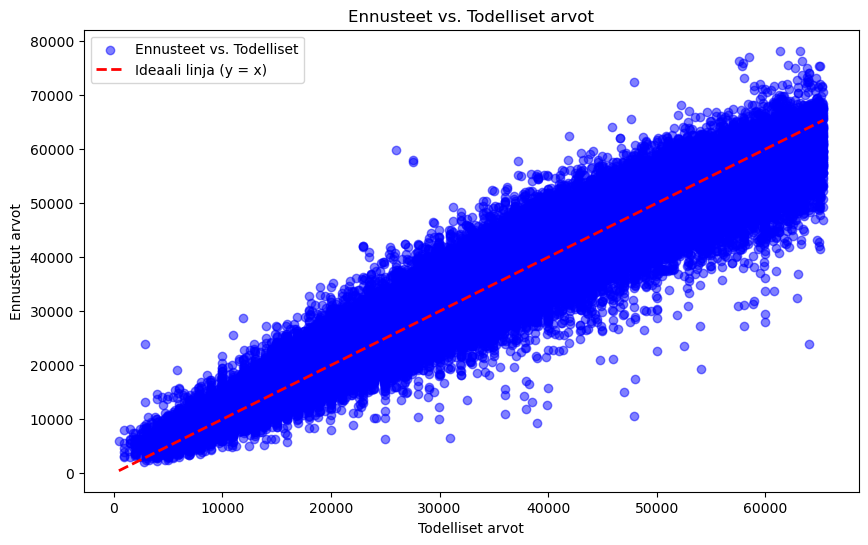

'\n480087952000.0000\n29555347948.5000\n10136951183.5000\n54642724604\n15399672672\n8629910492.0000\nEpoch 23/100, Loss: 14921280364.0000, LR: [2.5e-05]\nEpoch 7/100, Loss: 8629910492.0000, LR: [0.001]\nEpoch 15/100, Loss: 6140220020.0000, LR: [0.0005]\nEpoch 15/100, Loss: 6030494073.0000, LR: [0.0005]\nEpoch 50/100, Loss: 4350629643.0000, LR: [0.000125]\nEpoch 47/50, Loss: 5165631966.0000, LR: [6.25e-05]\nEpoch 48/50, Loss: 5155565226.0000, LR: [6.25e-05]\nEpoch 49/50, Loss: 5145456849.0000, LR: [6.25e-05]\nEpoch 50/50, Loss: 5136488866.0000, LR: [3.125e-05]\nMean Squared Error (MSE): 14340361.0000\nRoot Mean Squared Error (RMSE): 3786.8669\nMean Absolute Error (MAE): 2706.9407\nR-squared (R2): 0.9060\n'

In [8]:
import matplotlib.pyplot as plt

# Jos y_test_tensor on GPU-tensor, siirrä se CPU:lle ja muuta numpyksi
y_test_np = y_test_tensor.cpu().numpy()

# Ennusteiden vs. todellisten arvojen scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, predictions, alpha=0.5, color='blue', label='Ennusteet vs. Todelliset')
plt.plot([y_test_np.min(), y_test_np.max()],
         [y_test_np.min(), y_test_np.max()],
         color='red', linestyle='--', linewidth=2, label='Ideaali linja (y = x)')

# Kuvaajan otsikot ja selitteet
plt.xlabel("Todelliset arvot")
plt.ylabel("Ennustetut arvot")
plt.title("Ennusteet vs. Todelliset arvot")
plt.legend()
plt.show()

"""
480087952000.0000
29555347948.5000
10136951183.5000
54642724604
15399672672
8629910492.0000
Epoch 23/100, Loss: 14921280364.0000, LR: [2.5e-05]
Epoch 7/100, Loss: 8629910492.0000, LR: [0.001]
Epoch 15/100, Loss: 6140220020.0000, LR: [0.0005]
Epoch 15/100, Loss: 6030494073.0000, LR: [0.0005]
Epoch 50/100, Loss: 4350629643.0000, LR: [0.000125]
Epoch 47/50, Loss: 5165631966.0000, LR: [6.25e-05]
Epoch 48/50, Loss: 5155565226.0000, LR: [6.25e-05]
Epoch 49/50, Loss: 5145456849.0000, LR: [6.25e-05]
Epoch 50/50, Loss: 5136488866.0000, LR: [3.125e-05]
Mean Squared Error (MSE): 14340361.0000
Root Mean Squared Error (RMSE): 3786.8669
Mean Absolute Error (MAE): 2706.9407
R-squared (R2): 0.9060
"""

```
class EnhancedNN(nn.Module):
    def __init__(self, input_size):
        super(EnhancedNN, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3)  # Dropout lisää ylisovittamisen ehkäisyyn
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.fc4 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        self.output = nn.Linear(32, 1)  # Poistettu ylimääräinen ReLU

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return self.output(x)

# Alusta malli
model = EnhancedNN(X_train_tensor.shape[1]).to(device)

# Painojen alustus
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# Optimointi ja tappiofunktio
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Suurempi alkuperäinen learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)  # Oppimisnopeuden säätäjä
criterion = nn.MSELoss()
```
Epoch 48/50, Loss: 12.8047242
Epoch 49/50, Loss: 12.8022000
Epoch 50/50, Loss: 12.8049529

Suorituskykymittarit alkuperäisessä asteikossa:
Mean Squared Error (MSE): 0.04
Root Mean Squared Error (RMSE): 0.21
Mean Absolute Error (MAE): 0.17
R-squared (R2): -0.01

Ensimmäiset 10 ennustetta ja todelliset arvot alkuperäisessä skaalassa:
Ennuste: 1.23, Todellinen: 1.57
Ennuste: 1.24, Todellinen: 1.32
Ennuste: 1.24, Todellinen: 1.12
Ennuste: 1.23, Todellinen: 1.55
Ennuste: 1.24, Todellinen: 1.28
Ennuste: 1.24, Todellinen: 1.23
Ennuste: 1.24, Todellinen: 1.28
Ennuste: 1.23, Todellinen: 1.17
Ennuste: 1.24, Todellinen: 1.07
Ennuste: 1.24, Todellinen: 1.40
```
optimizer = optim.Adam(model.parameters(), lr=0.00001)
```
Epoch 48/50, Loss: 12.8324500
Epoch 49/50, Loss: 12.8301784
Epoch 50/50, Loss: 12.8290524

Suorituskykymittarit alkuperäisessä asteikossa:
Mean Squared Error (MSE): 0.04
Root Mean Squared Error (RMSE): 0.21
Mean Absolute Error (MAE): 0.17
R-squared (R2): -0.01

Ensimmäiset 10 ennustetta ja todelliset arvot alkuperäisessä skaalassa:
Ennuste: 1.24, Todellinen: 1.57
Ennuste: 1.24, Todellinen: 1.32
Ennuste: 1.24, Todellinen: 1.12
Ennuste: 1.24, Todellinen: 1.55
Ennuste: 1.23, Todellinen: 1.28
Ennuste: 1.24, Todellinen: 1.23
Ennuste: 1.24, Todellinen: 1.28
Ennuste: 1.23, Todellinen: 1.17
Ennuste: 1.24, Todellinen: 1.07
Ennuste: 1.24, Todellinen: 1.40
```
class ComplexNN(nn.Module):
    def __init__(self, input_size):
        super(ComplexNN, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc5 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return self.output(x)
```
Epoch 47/50, Loss: 12.8044621
Epoch 48/50, Loss: 12.8307362
Epoch 49/50, Loss: 12.8037963
Epoch 50/50, Loss: 12.8072244
Suorituskykymittarit alkuperäisessä asteikossa:
Mean Squared Error (MSE): 0.04
Root Mean Squared Error (RMSE): 0.21
Mean Absolute Error (MAE): 0.17
R-squared (R2): -0.00


```
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.output(x)

# Mallin alustaminen
model = SimpleNN(X_train_tensor.shape[1]).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 50
batch_size = 1024

# Luo DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Koulutus
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze().cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

# Suorituskykymittarit
mse = mean_squared_error(y_test_np, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_np, predictions)
r2 = r2_score(y_test_np, predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

```

Epoch 10/10, Loss: 29555347948.5000
Mean Squared Error (MSE): 9932098.0000
Root Mean Squared Error (RMSE): 3151.5232
Mean Absolute Error (MAE): 2262.5979
R-squared (R2): 0.9349


Epoch 50/50, Loss: 10136951183.5000
Mean Squared Error (MSE): 7174471.5000
Root Mean Squared Error (RMSE): 2678.5205
Mean Absolute Error (MAE): 1923.3870
R-squared (R2): 0.9530